In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf

from glob import glob
from re import findall,sub
from tqdm.notebook import tqdm

from tensorflow.compat.v1 import keras
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import  *
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras import backend as K

%matplotlib inline

In [4]:
images = glob("./lfw_funneled/*/*")

In [5]:
people = np.array([[" ".join(i.split("/")[-1].split("_")[:-1]),i] for i in images])

In [6]:
imgs = np.array([cv2.imread(i[1]) for i in tqdm(people)])

In [7]:
classes = set(people[:,0])
len(classes)

5749

In [8]:
imgs.shape

(13233, 250, 250, 3)

In [9]:
img = imgs[0]

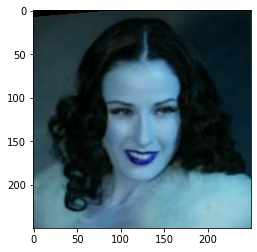

In [10]:
plt.imshow(img)

In [11]:
haar = cv2.CascadeClassifier()

In [12]:
haar.load("../haarcascade_frontalface_default.xml")

True

In [29]:
faces_name = []
faces_mask = []

error = []

for p,f in tqdm(zip(people[:,0],imgs),total=imgs.shape[0]):
    try:
        x,y,w,h = haar.detectMultiScale(img)[0]
        roi = cv2.resize(f[y:y+h,x:x+w],(64,64))
        faces_name.append(p)
        faces_mask.append(roi)
    except:
        error.append(p,f)

In [30]:
faces_name = np.array(faces_name)

In [31]:
faces_mask = np.array(faces_mask)

In [32]:
np.save("./fn.npy",faces_name,)
np.save("./fm.npy",faces_mask,)

In [3]:
faces_mask = np.load("./fm.npy")

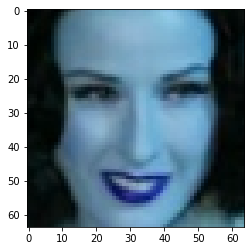

In [4]:
plt.imshow(faces_mask[0])

In [5]:
faces_mask.shape

(13233, 64, 64, 3)

In [7]:
labels = np.random.randint(0,1024,(faces_mask.shape[0],128))
train = faces_mask.copy()

In [8]:
def _gen(x,y,bs=10,epochs=1):
    for i in range(epochs):
        right = x.shape[0] % bs
        
        left_x = x[:-right].reshape(-1,bs,64,64,3)
        right_x = x[-right:]
        
        left_y = y[:-right].reshape(-1,bs,128)
        right_y = y[-right:]
        
        for _x,_y in zip(left_x,left_y):
            yield _x,_y 
        yield right_x,right_y

In [9]:
inputs = Input(shape=(64,64,3))

conv = Conv2D(8,4,activation="relu",input_shape=(64,64,3))(inputs)
conv = Conv2D(16,3,activation="relu",)(conv)
conv = Conv2D(32,2,activation="relu",)(conv)

flat = Flatten()(conv)
dense = Dense(128,activation="relu")(flat)
out = Dense(128)(dense)
embedding = Model(inputs,out)

embedding.compile(optimizer="adam",loss="mae")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [80]:
bs = 128
epochs = 5
gen = _gen(train,labels,bs=bs,epochs=epochs)
embedding.fit_generator(gen,steps_per_epoch=faces_mask.shape[0]//bs,epochs=epochs);

Epoch 1/5
103/103 [==============================] - 4s 38ms/step - loss: 301.6412
Epoch 2/5
103/103 [==============================] - 4s 35ms/step - loss: 259.4445
Epoch 3/5
103/103 [==============================] - 3s 34ms/step - loss: 258.0941
Epoch 4/5
103/103 [==============================] - 4s 34ms/step - loss: 256.5723
Epoch 5/5
103/103 [==============================] - 4s 34ms/step - loss: 254.9613


In [81]:
embedding.predict(faces_mask[0:2])

array([[542.4574 , 554.2512 , 590.05896, 386.1992 , 328.38644, 548.52844,
        339.12354, 370.65878, 496.62015, 483.59344, 378.68854, 414.4943 ,
        391.92102, 345.5223 , 365.61026, 464.51337, 421.31384, 421.5696 ,
        400.45337, 471.1726 , 514.53656, 431.86398, 451.9563 , 446.80786,
        428.40988, 286.50354, 548.25775, 367.77588, 331.61484, 490.94754,
        622.19305, 440.0306 , 374.36093, 519.3074 , 574.5162 , 437.47556,
        508.03333, 581.0614 , 380.28824, 417.45462, 361.29318, 466.78143,
        429.01306, 392.19296, 565.3343 , 454.22192, 579.3302 , 430.52716,
        303.59903, 469.23547, 518.0297 , 451.7979 , 508.20505, 394.11783,
        358.85675, 534.6544 , 379.26913, 440.71582, 481.78287, 588.2821 ,
        494.58582, 390.3366 , 573.84   , 380.1045 , 453.25485, 443.14462,
        383.39148, 346.80585, 473.44247, 370.02734, 355.35327, 431.42798,
        452.02316, 447.21472, 535.70874, 398.47165, 404.15955, 448.80353,
        595.2448 , 512.2503 , 494.9025

In [82]:
embedding.save_weights("./emb.h5")

In [10]:
embedding.load_weights("./emb.h5")

In [12]:
embedding.predict(faces_mask[0:2])

array([[542.4575 , 554.2514 , 590.05914, 386.19913, 328.38635, 548.5285 ,
        339.1236 , 370.65887, 496.62024, 483.59357, 378.68863, 414.49432,
        391.9211 , 345.5224 , 365.6102 , 464.5134 , 421.31393, 421.56973,
        400.45346, 471.17267, 514.5367 , 431.86398, 451.95636, 446.80795,
        428.40982, 286.50342, 548.2579 , 367.77597, 331.61475, 490.94763,
        622.1931 , 440.0307 , 374.3609 , 519.30743, 574.51636, 437.47562,
        508.03342, 581.0616 , 380.28824, 417.4546 , 361.29318, 466.78156,
        429.01318, 392.19293, 565.3345 , 454.222  , 579.33026, 430.52728,
        303.59897, 469.2355 , 518.02985, 451.7979 , 508.20514, 394.118  ,
        358.85663, 534.65454, 379.2693 , 440.71582, 481.78293, 588.2822 ,
        494.58588, 390.33655, 573.84   , 380.10458, 453.25494, 443.14465,
        383.39142, 346.80585, 473.4426 , 370.02728, 355.35315, 431.42807,
        452.02307, 447.21463, 535.7087 , 398.47162, 404.1595 , 448.80377,
        595.24506, 512.25037, 494.9026